### 1. Loading Libraries

In [1]:
# Computation
import numpy as np
import pandas as pd 

# Visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# Statistics
from scipy.stats import shapiro
import scipy.stats as stats

# Utils
import warnings
import os

%matplotlib inline

In [2]:
import pymc3 as pm
import arviz as az 
pd.options.display.max_columns = None

In [10]:
mpl.style.use("fivethirtyeight")

### 2. Loading Data

In [3]:
df = pd.read_csv('../data/final_df.csv')

In [4]:
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90183,9999441,gate_40,97,True,False
90184,9999479,gate_40,30,False,False
90185,9999710,gate_30,28,True,False
90186,9999768,gate_40,51,True,False


### 3. Bayesian Models - 1-Day Retention

* Priori: Uniform with an interval between [0.1]
* Likelihood: Bernoulli

In [5]:
g30_1 = df.query("version == 'gate_30'")['retention_1'].values.astype(int)
g40_1 = df.query("version == 'gate_40'")['retention_1'].values.astype(int)

In [6]:
with pm.Model() as model_30:
    
    p_30 = pm.Uniform('p_30',lower=0, upper=1)
    
    obs_30 = pm.Bernoulli('obs_30', p_30, observed=g30_1)
    
    step = pm.Metropolis()
    trace = pm.sample(2000, step = step)
    burned_trace_30 = trace[1000:]

/opt/anaconda3/envs/sl_app/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [p_30]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 26 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [7]:
with pm.Model() as model_40:
    p_40 = pm.Uniform('p_40',lower=0, upper=1)
    
    obs_40 = pm.Bernoulli('obs_40', p_40, observed=g40_1)
    
    step = pm.Metropolis()
    trace = pm.sample(2000, step = step)
    burned_trace_40 = trace[1000:]

/opt/anaconda3/envs/sl_app/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [p_40]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 22 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [8]:
# Observing the mean of the two distributions with the posterior values ​​generated

print(f'Mean posteriori Gate 30: {burned_trace_30["p_30"].mean().round(3)}')
print(f'Mean posteriori Gate 40: {burned_trace_40["p_40"].mean().round(3)}')

Mean posteriori Gate 30: 0.448
Mean posteriori Gate 40: 0.442


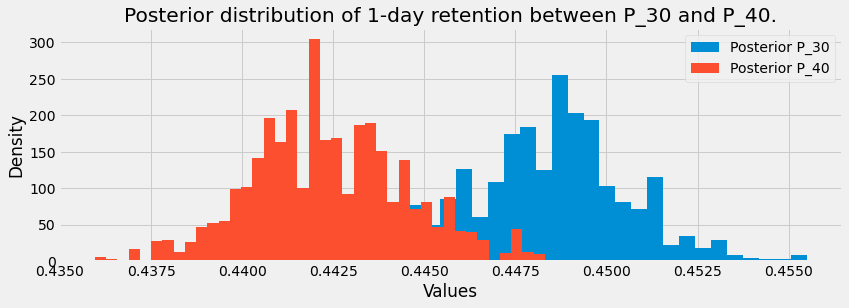

In [12]:
fig = plt.figure(figsize=(12.5, 4))
plt.hist(burned_trace_30["p_30"], bins=40, label='Posterior P_30', density=True)
plt.hist(burned_trace_40["p_40"], bins=40, label='Posterior P_40', density=True)
plt.xlabel('Values')
plt.ylabel('Density')
plt.title("Posterior distribution of 1-day retention between P_30 and P_40.")
plt.legend()
plt.show()

fig.savefig('../eda/1_day_posterior.png', dpi=fig.dpi)

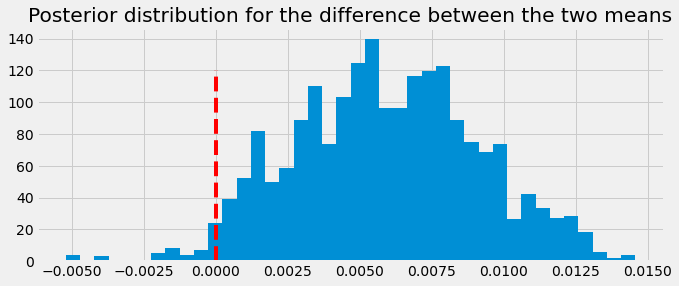

In [13]:
diff=burned_trace_30["p_30"]-burned_trace_40["p_40"]
fig = plt.figure(figsize=(10, 4))
plt.hist(diff, bins=40, density=True)
plt.vlines(0, 0, 120, linestyle='--', color='red')
plt.title('Posterior distribution for the difference between the two means')
plt.show()

fig.savefig('../eda/1_day_posterior_diff.png', dpi=fig.dpi)

In [17]:
# Probability that the difference is larger than 0
100*len(diff[diff>0.0])*1.0/len(diff)

95.7

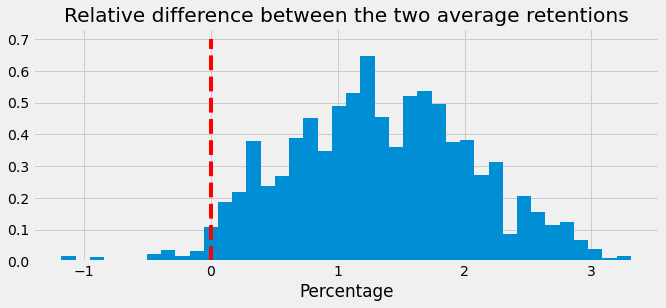

In [14]:
rel_diff=100*(burned_trace_30["p_30"]-burned_trace_40["p_40"])/burned_trace_40["p_40"]
fig = plt.figure(figsize=(10, 4))
plt.hist(rel_diff, bins=40, density=True)
plt.vlines(0, 0, 0.7, linestyle='--', color='red')
plt.title('Relative difference between the two average retentions')
plt.xlabel("Percentage")
plt.show()

fig.savefig('../eda/1_day_posterior_rel.png', dpi=fig.dpi)

In [19]:
100*len(rel_diff[rel_diff>0.0])*1.0/len(rel_diff)

95.7

#### Conclusion:

From the above observations, we have a 95.7% confidence that the retention for Gate 30 is greater than 40.

### 4. Bayesian Models - 7-Day Retention

In [15]:
g30_7 = df.query("version == 'gate_30'")['retention_7'].values.astype(int)
g40_7 = df.query("version == 'gate_40'")['retention_7'].values.astype(int)
print(f'Mean 7-Day Retention of Gate 30: {100*g30_7.mean().round(3)}%')
print(f'Mean 7-Day Retention of Gate 40: {100*g40_7.mean().round(3)}%')
print(f'Difference between Gate 30 and Gate 40: {(g30_7.mean() - g40_7.mean()).round(3)*100}%')

Mean 7-Day Retention of Gate 30: 19.0%
Mean 7-Day Retention of Gate 40: 18.2%
Difference between Gate 30 and Gate 40: 0.8%


In [16]:
with pm.Model() as model_7_30_v2:
    p_7_30 = pm.Uniform('p_7_30',lower=0, upper=1)
    p_7_40 = pm.Uniform('p_7_40',lower=0, upper=1)
    
    obs_7_30 = pm.Bernoulli('obs_7_30', p_7_30, observed=g30_7)
    obs_7_40 = pm.Bernoulli('obs_7_40', p_7_40, observed=g40_7)
    
    diff = pm.Deterministic('diff', p_7_30 - p_7_40)
    rel_diff = pm.Deterministic('rel_diff', 100*(p_7_30 - p_7_40)/p_7_40)
    
    step = pm.Metropolis()
    trace = pm.sample(2000, step = step)
    burned_trace_7 = trace[1000:]

/opt/anaconda3/envs/sl_app/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_7_40]
>Metropolis: [p_7_30]


In [26]:
# Observing the mean of the two distributions with the posterior values ​​generated
print(f'Mean posteriori for Gate 30: {burned_trace_7["p_7_30"].mean().round(3)}')
print(f'Mean posteriori for Gate 40: {burned_trace_7["p_7_40"].mean().round(3)}')

Mean posteriori for Gate 30: 0.19
Mean posteriori for Gate 40: 0.182


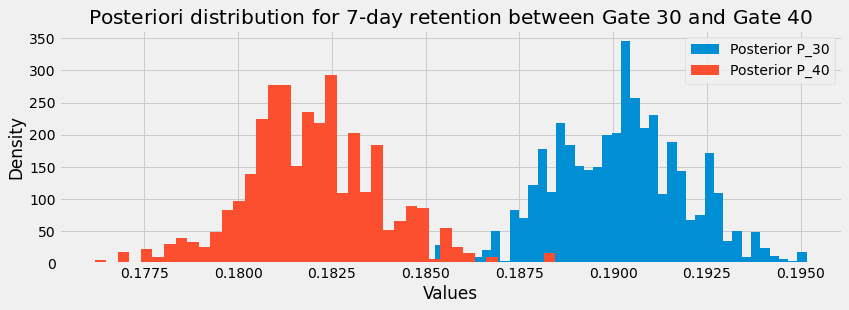

In [27]:
plt.figure(figsize=(12.5, 4))
plt.hist(burned_trace_7["p_7_30"], bins=40, label='Posterior P_30', density=True)
plt.hist(burned_trace_7["p_7_40"], bins=40, label='Posterior P_40', density=True)
plt.xlabel('Values')
plt.ylabel('Density')
plt.title("Posteriori distribution for 7-day retention between Gate $30$ and Gate $40$")
plt.legend()
plt.show()

fig.savefig('../eda/7_day_posterior.png', dpi=fig.dpi)

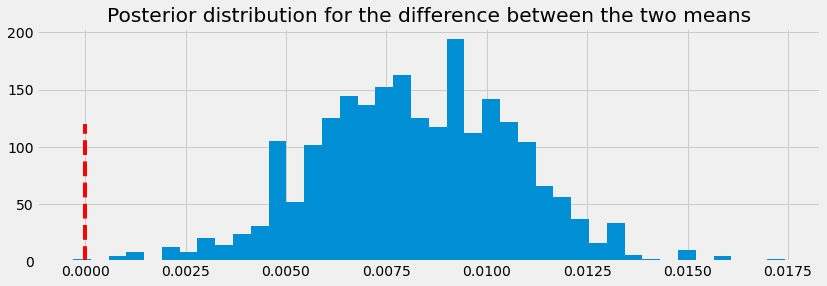

In [28]:
diff=burned_trace_7["p_7_30"]-burned_trace_7["p_7_40"]
plt.figure(figsize=(12.5, 4))
plt.hist(diff, bins=40, density=True)
plt.vlines(0, 0, 120, linestyle='--', color='red')
plt.title('Posterior distribution for the difference between the two means')
plt.show()

fig.savefig('../eda/7_day_posterior_diff.png', dpi=fig.dpi)

In [29]:
# Probability that the difference is larger than 0
100*len(diff[diff>0.0])*1.0/len(diff)

99.9

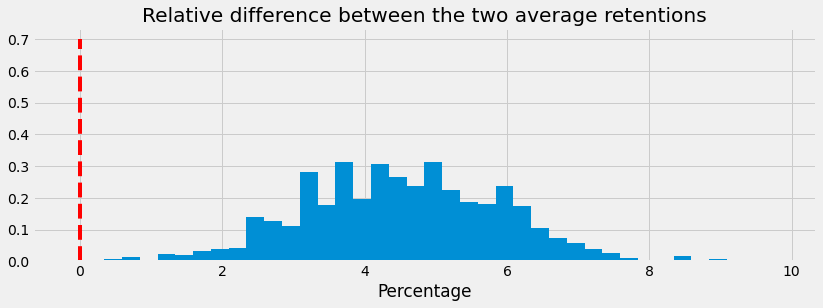

In [30]:
rel_diff=100*(burned_trace_7["p_7_30"]-burned_trace_7["p_7_40"])/burned_trace_7["p_7_40"]
plt.figure(figsize=(12.5, 4))
plt.hist(rel_diff, bins=40, density=True)
plt.vlines(0, 0, 0.7, linestyle='--', color='red')
plt.title('Relative difference between the two average retentions')
plt.xlabel("Percentage")
plt.show()

fig.savefig('../eda/7_day_posterior_rel.png', dpi=fig.dpi)


In [31]:
100*len(rel_diff[rel_diff>0.0])*1.0/len(rel_diff)

99.9

### Conclusion 7 day retention

From the above observations, we have a 99.9% confidence that the retention for Gate 30 is greater than 40 for 7 days. 

As a final conclusion we observed that placing the gate at Level 30 brought greater retention for both the 1 and 7 days metrics. For decision making in a real problem, other variables would need to be analyzed, however, if the decision needed to be taken taking into account only those studied, the Gate 30 maintenance would be the most adequate.